<a href="https://colab.research.google.com/github/bishair/Pirna/blob/main/G29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import display
import joblib
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l1_l2


In [ ]:
'''import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Example parameters
n_features = 1  # number of features in your data; modify as per your dataset
input_sequence_length = 24  # number of time steps in the input
output_sequence_length = 24  # number of time steps to predict

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(input_sequence_length, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(output_sequence_length))

model.compile(optimizer='adam', loss='mean_squared_error')

# Example input data shape: (number of samples, input_sequence_length, n_features)
# Example output data shape: (number of samples, output_sequence_length)

# Mock data for demonstration (replace with your actual data)
X_train = np.random.random((100, input_sequence_length, n_features))  # replace with your training data
y_train = np.random.random((100, output_sequence_length))  # replace with your training labels

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# To make a prediction
# X_test should be of shape (number of samples, input_sequence_length, n_features)
X_test = np.random.random((10, input_sequence_length, n_features))  # replace with your test data
predicted = model.predict(X_test)

# 'predicted' is an array of predictions, each with a length of output_sequence_length (24 in this case)'''


In [2]:
uploaded_file = files.upload()

Saving trainingdata.csv to trainingdata.csv


In [3]:
# Load the data
data = pd.read_csv('trainingdata.csv')

In [4]:
# Filter the data for waterpoint_id 3
gw = data[data['waterpoints_id'] == 3]
#print(gw)

In [5]:
gw.dropna(inplace=True)
#print(gw)

<ipython-input-5-0527c3859693>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gw.dropna(inplace=True)


In [6]:
gw = gw.drop(['id', 'waterpoints_id', 'waterpoints_name'], axis=1)
gw.rename(columns={'water_level': 'G29', 'date_time': 'Date'}, inplace=True)
#print(gw)

In [7]:
# Filter the data for waterpoint_id 6
river = data[data['waterpoints_id'] == 6]
#print(river)

In [8]:
river.dropna(inplace=True)
#print(river)

<ipython-input-8-04faa066f5bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  river.dropna(inplace=True)


In [9]:
river = river.drop(['id', 'waterpoints_id', 'waterpoints_name'], axis=1)
river.rename(columns={'water_level': 'river', 'date_time': 'Date'}, inplace=True)
#print(river)

In [10]:
gw['Date'] = pd.to_datetime(gw['Date'], format='%m/%d/%Y %H:%M')
river['Date'] = pd.to_datetime(river['Date'], format='%m/%d/%Y %H:%M')

In [11]:
# Merge the two datasets on the 'Date' column
merged_data = pd.merge_asof(gw.sort_values('Date'), river.sort_values('Date'), on='Date', direction='nearest')
# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)
print(merged_data)

                         G29    river
Date                                 
2022-12-19 06:00:00  109.755  115.700
2022-12-19 07:00:00  109.753  115.690
2022-12-19 08:00:00  109.750  115.690
2022-12-19 09:00:00  109.747  115.690
2022-12-19 10:00:00  109.745  115.680
...                      ...      ...
2023-12-28 08:00:00  112.605  120.415
2023-12-28 09:00:00  112.613  120.425
2023-12-28 10:00:00  112.621  120.430
2023-12-28 11:00:00  112.629  120.440
2023-12-28 12:00:00  112.637  120.440

[6045 rows x 2 columns]


In [21]:
n_steps_in, n_steps_out = 24, 24

# Assuming merged_data is your dataset
train_size = int(len(merged_data) * 0.7)
resampled_data_train = merged_data[:train_size]
resampled_data_test = merged_data[train_size:]

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(resampled_data_train)
test_scaled = scaler.transform(resampled_data_test)

joblib.dump(scaler, 'scaler.gz')

# Modified function to create sequences
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(n_steps_in, len(data) - n_steps_out + 1):
        X.append(data[i-n_steps_in:i, :])
        y.append(data[i:i+n_steps_out, 0])
    return np.array(X), np.array(y)

# Create sequences for training and testing sets
X_train, y_train = create_sequences(train_scaled, n_steps_in, n_steps_out)
X_test, y_test = create_sequences(test_scaled, n_steps_in, n_steps_out)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (4184, 24, 2)
y_train shape: (4184, 24)
X_test shape: (1767, 24, 2)
y_test shape: (1767, 24)


In [14]:
#print(X_train, X_train.shape)

In [ ]:
#print(X_test, X_test.shape)

In [16]:
#print(y_train, y_train.shape)
#print(y_test, y_test.shape)

In [22]:
# Define the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(n_steps_in, train_scaled.shape[1]),
         dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.2),
    LSTM(units=50, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(n_steps_out)  # Output layer for predicting the next 12 values
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
66/66 [==============================] - 12s 65ms/step - loss: 0.3452
Epoch 2/50
66/66 [==============================] - 4s 64ms/step - loss: 0.1051
Epoch 3/50
66/66 [==============================] - 6s 89ms/step - loss: 0.0260
Epoch 4/50
66/66 [==============================] - 4s 65ms/step - loss: 0.0140
Epoch 5/50
66/66 [==============================] - 5s 76ms/step - loss: 0.0115
Epoch 6/50
66/66 [==============================] - 5s 79ms/step - loss: 0.0104
Epoch 7/50
66/66 [==============================] - 4s 65ms/step - loss: 0.0089
Epoch 8/50
66/66 [==============================] - 6s 85ms/step - loss: 0.0091
Epoch 9/50
66/66 [==============================] - 4s 67ms/step - loss: 0.0085
Epoch 10/50
66/66 [==============================] - 4s 64ms/step - loss: 0.0080
Epoch 11/50
66/66 [==============================] - 6s 88ms/step - loss: 0.0072
Epoch 12/50
66/66 [==============================] - 6s 89ms/step - loss: 0.0071
Epoch 13/50
66/66 [=================

In [23]:
mse = model.evaluate(X_test, y_test)
print(mse)


56/56 [==============================] - 2s 16ms/step - loss: 0.0019
0.0019410719396546483


In [24]:
model.save('lstmmodel.h5')
model = load_model('lstmmodel.h5')
scaler = joblib.load('scaler.gz')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Take the last 24 hour data
#Preprocess this using similar steps used before for creating a merged dataframe to combine river and gw values
#Preprocess the merged dataframe to create a 3D array for input to the model.predict function




In [39]:
uploaded_file = files.upload()

Saving trainingdataOct.csv to trainingdataOct.csv


In [59]:
# Load the data
data = pd.read_csv('trainingdataOct.csv')

In [60]:
# Filter the data for waterpoint_id 3
gwR = data[data['waterpoints_id'] == 3]
print(gwR.shape)

(6069, 5)


In [61]:
# Filter the data for waterpoint_id 3
gwR = data[data['waterpoints_id'] == 3]
print(gwR)

          id         date_time  water_level  waterpoints_id waterpoints_name
2652    2667  10/31/2023 13:00      109.594               3           CDT125
2653    2668  10/31/2023 14:00      109.593               3           CDT125
2654    2669  10/31/2023 15:00      109.592               3           CDT125
2655    2670  10/31/2023 16:00      109.591               3           CDT125
2656    2671  10/31/2023 17:00      109.589               3           CDT125
...      ...               ...          ...             ...              ...
19389  19404    7/1/2023 19:00      109.366               3           CDT125
19390  19405    7/1/2023 20:00      109.364               3           CDT125
19391  19406    7/1/2023 21:00      109.362               3           CDT125
19392  19407    7/1/2023 22:00      109.361               3           CDT125
19393  19408    7/1/2023 23:00      109.359               3           CDT125

[6069 rows x 5 columns]


In [62]:
gwR.dropna(inplace=True)
print(gwR)

          id         date_time  water_level  waterpoints_id waterpoints_name
2652    2667  10/31/2023 13:00      109.594               3           CDT125
2653    2668  10/31/2023 14:00      109.593               3           CDT125
2654    2669  10/31/2023 15:00      109.592               3           CDT125
2655    2670  10/31/2023 16:00      109.591               3           CDT125
2656    2671  10/31/2023 17:00      109.589               3           CDT125
...      ...               ...          ...             ...              ...
19389  19404    7/1/2023 19:00      109.366               3           CDT125
19390  19405    7/1/2023 20:00      109.364               3           CDT125
19391  19406    7/1/2023 21:00      109.362               3           CDT125
19392  19407    7/1/2023 22:00      109.361               3           CDT125
19393  19408    7/1/2023 23:00      109.359               3           CDT125

[6069 rows x 5 columns]


<ipython-input-62-85cb54704371>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwR.dropna(inplace=True)


In [63]:
gwR = gwR.drop(['id', 'waterpoints_id', 'waterpoints_name'], axis=1)
gwR.rename(columns={'water_level': 'G29', 'date_time': 'Date'}, inplace=True)
print(gwR)

                   Date      G29
2652   10/31/2023 13:00  109.594
2653   10/31/2023 14:00  109.593
2654   10/31/2023 15:00  109.592
2655   10/31/2023 16:00  109.591
2656   10/31/2023 17:00  109.589
...                 ...      ...
19389    7/1/2023 19:00  109.366
19390    7/1/2023 20:00  109.364
19391    7/1/2023 21:00  109.362
19392    7/1/2023 22:00  109.361
19393    7/1/2023 23:00  109.359

[6069 rows x 2 columns]


In [64]:
# Filter the data for waterpoint_id 6
riverR = data[data['waterpoints_id'] == 6]
print(riverR)

          id        date_time  water_level  waterpoints_id waterpoints_name
19394  19409   1/20/2023 9:00       116.75               6      pirna_gauge
19395  19410  1/20/2023 10:00       116.75               6      pirna_gauge
19396  19411  1/20/2023 11:00       116.76               6      pirna_gauge
19397  19412  1/20/2023 12:00       116.76               6      pirna_gauge
19398  19413  1/20/2023 13:00       116.74               6      pirna_gauge
...      ...              ...          ...             ...              ...
29311  29326  1/17/2023 19:00       116.86               6      pirna_gauge
29312  29327  1/17/2023 20:00       116.86               6      pirna_gauge
29313  29328  1/17/2023 21:00       116.86               6      pirna_gauge
29314  29329  1/17/2023 22:00       116.86               6      pirna_gauge
29315  29330  1/17/2023 23:00       116.86               6      pirna_gauge

[9909 rows x 5 columns]


In [65]:
riverR.dropna(inplace=True)
print(riverR)

          id        date_time  water_level  waterpoints_id waterpoints_name
19394  19409   1/20/2023 9:00       116.75               6      pirna_gauge
19395  19410  1/20/2023 10:00       116.75               6      pirna_gauge
19396  19411  1/20/2023 11:00       116.76               6      pirna_gauge
19397  19412  1/20/2023 12:00       116.76               6      pirna_gauge
19398  19413  1/20/2023 13:00       116.74               6      pirna_gauge
...      ...              ...          ...             ...              ...
29311  29326  1/17/2023 19:00       116.86               6      pirna_gauge
29312  29327  1/17/2023 20:00       116.86               6      pirna_gauge
29313  29328  1/17/2023 21:00       116.86               6      pirna_gauge
29314  29329  1/17/2023 22:00       116.86               6      pirna_gauge
29315  29330  1/17/2023 23:00       116.86               6      pirna_gauge

[9906 rows x 5 columns]


<ipython-input-65-2cf0418bd735>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  riverR.dropna(inplace=True)


In [66]:
riverR = riverR.drop(['id', 'waterpoints_id', 'waterpoints_name'], axis=1)
riverR.rename(columns={'water_level': 'river', 'date_time': 'Date'}, inplace=True)
print(riverR)

                  Date   river
19394   1/20/2023 9:00  116.75
19395  1/20/2023 10:00  116.75
19396  1/20/2023 11:00  116.76
19397  1/20/2023 12:00  116.76
19398  1/20/2023 13:00  116.74
...                ...     ...
29311  1/17/2023 19:00  116.86
29312  1/17/2023 20:00  116.86
29313  1/17/2023 21:00  116.86
29314  1/17/2023 22:00  116.86
29315  1/17/2023 23:00  116.86

[9906 rows x 2 columns]


In [67]:

gwR['Date'] = pd.to_datetime(gw['Date'], format='%m/%d/%Y %H:%M')
riverR['Date'] = pd.to_datetime(river['Date'], format='%m/%d/%Y %H:%M')

In [68]:
# Merge the two datasets on the 'Date' column
real_time_data = pd.merge_asof(gwR.sort_values('Date'), riverR.sort_values('Date'), on='Date', direction='nearest')
# Set 'Date' as the index
real_time_data.set_index('Date', inplace=True)
print(real_time_data)

                         G29    river
Date                                 
2022-12-19 06:00:00  109.755  115.700
2022-12-19 07:00:00  109.753  115.690
2022-12-19 08:00:00  109.750  115.690
2022-12-19 09:00:00  109.747  115.690
2022-12-19 10:00:00  109.745  115.680
...                      ...      ...
2023-12-28 08:00:00  112.605  120.415
2023-12-28 09:00:00  112.613  120.425
2023-12-28 10:00:00  112.621  120.430
2023-12-28 11:00:00  112.629  120.440
2023-12-28 12:00:00  112.637  120.440

[6069 rows x 2 columns]


1/1 [==============================] - 0s 69ms/step


<ipython-input-72-b90b14115793>:33: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_timestamps = pd.date_range(start=real_time_data.index[-1], periods=25, closed='right', freq='H')


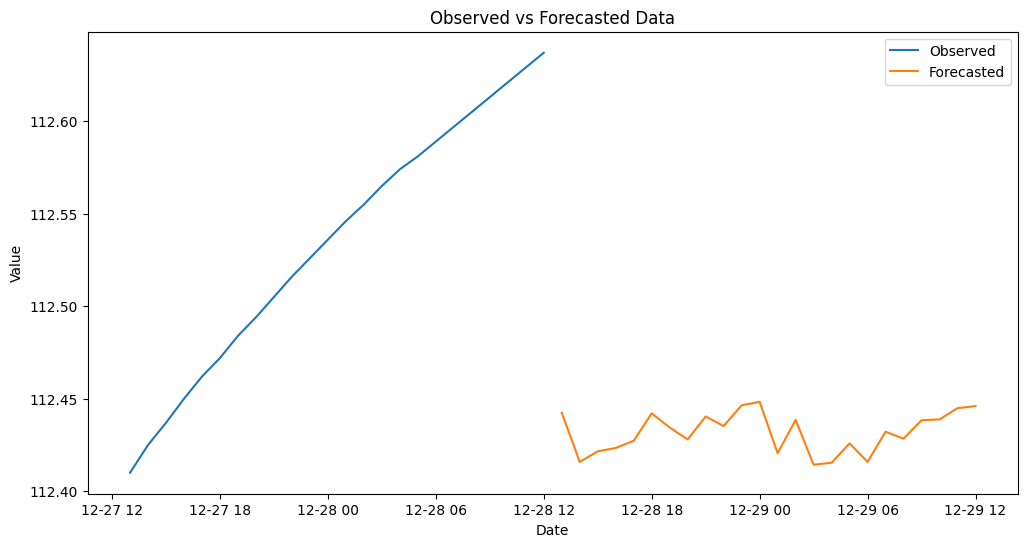

In [72]:
'''

# Assuming real_time_data is your DataFrame
# Fetch the last 24 hours of data
last_24_hours = real_time_data.iloc[-24:]

# Scale the last 24 hours of data
last_24_hours_scaled = scaler.transform(last_24_hours)

# Reshape the data to match the input shape of the model (1, 24, number_of_features)
last_24_hours_scaled = last_24_hours_scaled.reshape(1, 24, last_24_hours_scaled.shape[1])

# Make predictions for the next 24 hours
predicted_24_hours_scaled = model.predict(last_24_hours_scaled)

# Initialize an array to store the inverse transformed predictions
forecasted_values = np.zeros(predicted_24_hours_scaled.shape[1])

# Inverse transform each predicted point individually
for i in range(predicted_24_hours_scaled.shape[1]):
    # Create an array with the shape the scaler expects
    temp_array = np.zeros((1, last_24_hours_scaled.shape[2]))
    temp_array[0, 0] = predicted_24_hours_scaled[0, i]  # Assuming the forecasted feature is the first feature

    # Inverse transform and store the result
    forecasted_values[i] = scaler.inverse_transform(temp_array)[0, 0]

# Plotting
plt.figure(figsize=(12, 6))

# Plot the observed data
plt.plot(real_time_data.index[-24:], real_time_data.iloc[-24:, 0], label='Observed')

# Generate future timestamps for the forecasted data
future_timestamps = pd.date_range(start=real_time_data.index[-1], periods=25, closed='right', freq='H')

# Plot the forecasted data
plt.plot(future_timestamps, forecasted_values, label='Forecasted')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Observed vs Forecasted Data')
plt.legend()
plt.show() '''


189/189 [==============================] - 4s 22ms/step


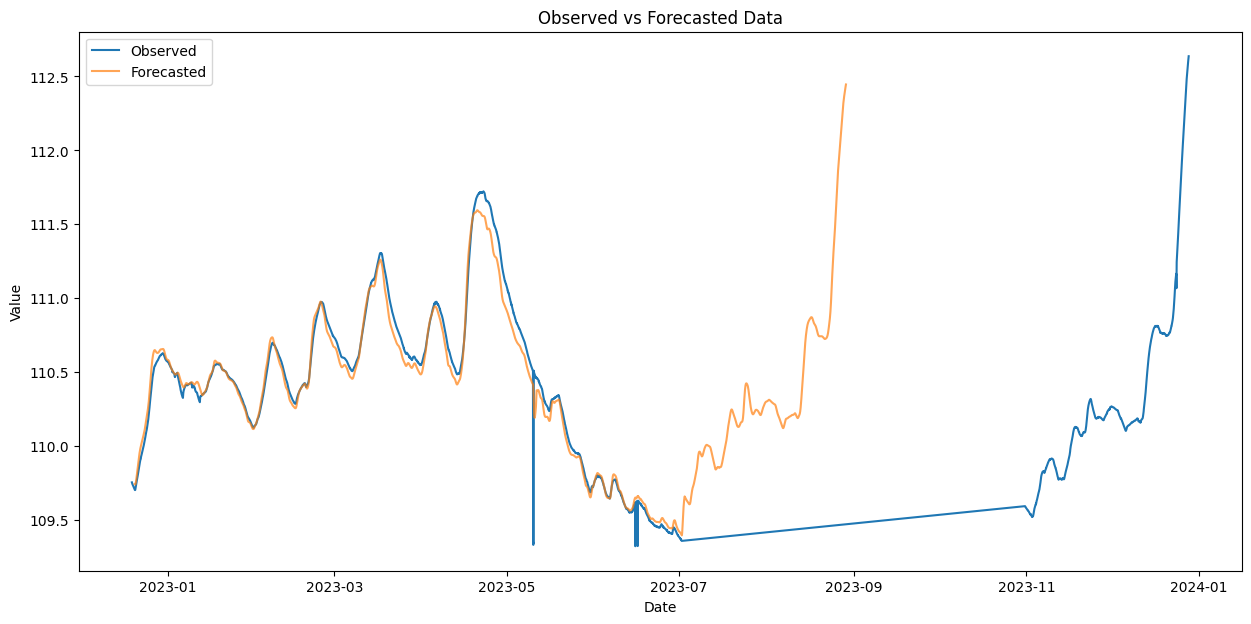

In [77]:



# Assuming real_time_data is your DataFrame and has been scaled using the MinMaxScaler
# Prepare the sequences using a sliding window approach
input_sequences = np.array([real_time_data_scaled[i - 24:i] for i in range(24, len(real_time_data_scaled)+1)])

# Make predictions for each sequence
predicted_sequences_scaled = model.predict(input_sequences)

# Initialize a list to store the inverse transformed predictions
forecasted_values = []

# Inverse transform the predicted values one by one
for i in range(predicted_sequences_scaled.shape[0]):
    # Create an array to inverse transform that matches the scaler's expected number of features
    to_inverse = np.zeros((1, real_time_data_scaled.shape[1]))
    to_inverse[0, 0] = predicted_sequences_scaled[i, -1]  # Assuming the first column is the target
    # Inverse transform and store the result
    forecasted_values.append(scaler.inverse_transform(to_inverse)[0, 0])

# Plotting
plt.figure(figsize=(15, 7))

# Plot the observed data
plt.plot(real_time_data.index, real_time_data.iloc[:, 0], label='Observed')

# Generate future timestamps for the forecasted data
forecast_timestamps = pd.date_range(start=real_time_data.index[24], periods=len(forecasted_values), freq='H')

# Plot the forecasted data
plt.plot(forecast_timestamps, forecasted_values, label='Forecasted', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Observed vs Forecasted Data')
plt.legend()
plt.show()
